In [117]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
from abtem.core.parametrizations import (
    KirklandParametrization,
    LobatoParametrization,
    PengParametrization,
)
from ase.io import read

(walkthrough:potentials)=
# Potentials
An electron beam interacts with a specimen principally through the Coulomb potential of its electrons and nuclei. Thus the total electrostatic potential of the sample is required for image simulations. Typically, a so-called independent atom model (IAM) is used, which calculates the potential as a superposition of atomic potentials, hence neglecting effects due to valence bonding.

## Atomic potential parametrization

The electron charge distribution of a single atom can be calculated from a first-principles electronic structure calculation, for example using the [Hartree-Fock method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) or [density functional theory](https://en.wikipedia.org/wiki/Density_functional_theory). Given a charge distribution, the potential can be obtained via [Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation). Most multislice simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to the potential calculated elsewhere from first principles. 

We show the radial dependence of the electrostatic potential of five selected elements below. Note that the potentials tend to infinity at $r=0$ due to the point-like nuclear charge.

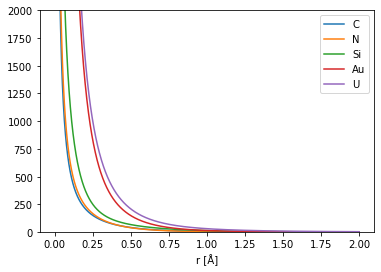

In [118]:
symbols = ["C", "N", "Si", "Au", "U"]

potentials = abtem.concatenate(
    [
        LobatoParametrization().line_profiles(
            symbol,
            cutoff=2,
            name="potential",
        )
        for symbol in symbols
    ]
)


fig, ax = potentials.show()
ax.set_ylim([0, 2000]);

The default parametrization in abTEM, which is shown above, is created by Ivan Lobato{cite}`lobato-parameters`. We also implement the parametrization by Earl J. Kirkland{cite}`kirkland` and the parametrization by Peng{cite}`peng-parameters`. The differences between the parametrizations are generally negligible at low scattering angles, but the parametrization by Lobato is more accurate at higher angles{cite}`lobato-parameters`.

# Independent atom model
The full specimen potential, $V(r)$, is usually obtained as a linear superposition of atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This is known as the independent atom model (IAM), and as a superposition of independent atoms, it neglects bonding effects. While this is in many cases an adequate approximation, there are situations where that is not the case ({cite}`madsen_ab_initio`) which *ab*TEM is particularly designed to address (as discussed [later in the walkthrough](walkthrough:charge_density).

## `Potential`
Here, we create a `Potential` object representing an IAM potential of SrTiO<sub>3</sub> with the Lobato parametrization. The `sampling` denotes the spacing of the $xy$-samples of the potential, `slice_thickness` determines the spacing the slices in direction of electron beam and `projection` determines how those slices are calculated (as described [later in this document](walkthrough:slicing)).

We also repeat the structure to make a larger supercell for visualizations.

In [3]:
srtio3 = read("./data/SrTiO3.cif")
repeated_srtio3 = srtio3 * (2, 2, 6)

potential = abtem.Potential(
    repeated_srtio3,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

The potential has 24 slices along the $z$ propagation direction, as may be determined from getting its length.

In [4]:
len(potential)

24

The projected potential, i.e. the sum of all the slices multiplied by the thickness, may be shown using the `show` method.

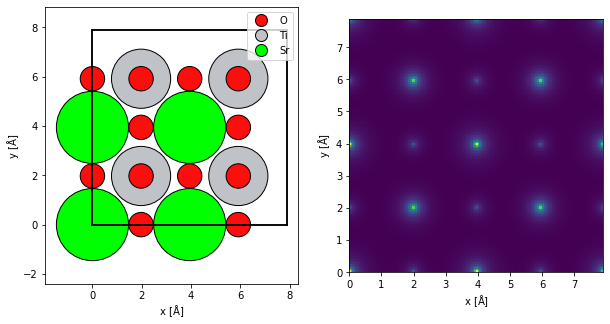

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(repeated_srtio3, ax=ax1, legend=True)

visualization = potential.show(ax=ax2);

The `Potential` may be indexed to return a subset of slices. Below we select every sixth slice (using the Python syntax for indexing lists, `[::6]`) and show them all by setting `project=False` (the default is to show the projected potential) and `explode=True` (which automatically creates a multi-panel figure; in this instance the latter setting is assumed if the former is set). The titles of the panels are automatically set based on the selected slices.

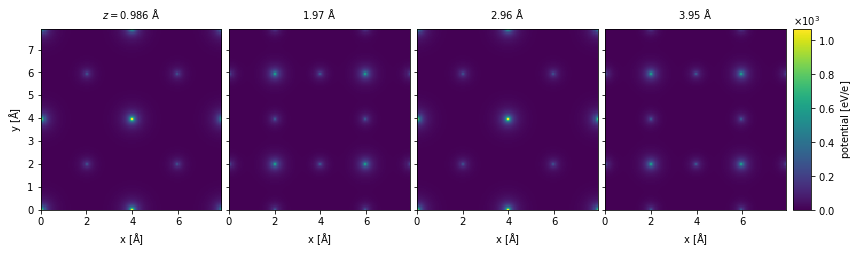

In [120]:
visualization = potential[::6].show(
    project=False, explode=True, figsize=(14, 5), common_color_scale=True, cbar=True,
)

## Building and saving the potential
The `Potential` does not store the calculated potential slices. Hence, if a simulation, such as STEM requires multiple propagations, each slice have to be calculated multiple times. For this reason, *ab*TEM often precalculates the potential whenever it has to be used more than once. 

The potential can be precalculated manually using the `build` method, but you should typically let *ab*TEM decide whether to precalculate the potential. Note that we also need to `compute` it, *ab*TEM by default uses so-called lazy arrays (see our [description of Dask](walkthrough:parallelization) for detail); a progress bar is displayed by default.

In [108]:
potential_array = potential.build().compute()

[########################################] | 100% Completed | 2.50 ss


This returns an `PotentialArray` object, which stores each 2D potential slice in a 3D array. The first dimension is the slice index and the last two are the spatial dimensions.

In [109]:
potential_array.shape

(24, 158, 158)

The calculated potential can be stored in the open-source [Zarr file format](https://zarr.readthedocs.io/en/stable/) and conveniently read back in.

In [110]:
potential_array.to_zarr("data/srtio3_repeated_potential.zarr", overwrite=True)

abtem.from_zarr("data/srtio3_repeated_potential.zarr");

[########################################] | 100% Completed | 102.48 ms


(walkthrough:slicing)= 
## Slicing the potential

The multislice algorithm underlying most modern TEM image simulations requires a mathematical discretization of the potential into slices, which is exact in the limit of infinitely thin slices. The slice thickness can be considered a convergence parameter, and since more slices increases the computational cost, an optimum providing sufficient precision at an acceptable cost can be selected.

A reasonable value for slice thickness is generally between $0.5 \ \mathrm{Å}$ and $2 \ \mathrm{Å}$; our default value is $1 \ \mathrm{Å}$. *ab*TEM also provides multiple options for evaluating the integrals required for slicing the potential that make slightly different tradeoffs in terms of precision and performance.

### Finite projection integrals

*ab*TEM implements an accurate finite potential projection method. Numerical integration is used to calculate the integrals of the form

$$
V_{n}(x, y) = \int_{z_n}^{z_n+\Delta z} V(x,y,z) dz \quad ,
$$ (eq:potentials:slice)

where $z_n$ is the $z$-position at the entrance of the $n$'th slice and $\Delta z$ is the slice thickness.

We used the *ab*TEM default method of handling finite projection integrals above; additional options and a description of the methods is given in [an appendix](../appendix/potential_integrals.ipynb). 

### Infinite projection integrals

Since the finite projection method can be computationally demanding, *ab*TEM also implements potentials using infinite projection integrals. The finite integrals are replaced by infinite integrals, which may be evaluated analytically

$$ \int_{-\infty}^{\infty} V(x,y,z) dz \approx \int_{z_i}^{z_i+\Delta z} V(x,y,z) dz $$

The infinite projection of the atomic potential for each atom is assigned to a single slice. The implementation uses the hybrid real-space/Fourier-space approach by van den Broek {cite}`van_den_broek_infinite_projections`). 

Below we create the same SrTiO3 potential as above with infinite projections. The potential looks almost identical to the finite projection, but note that the slice at $z=2.96 \ \mathrm{Å}$ has zero intensity because there is not atoms in this slice.

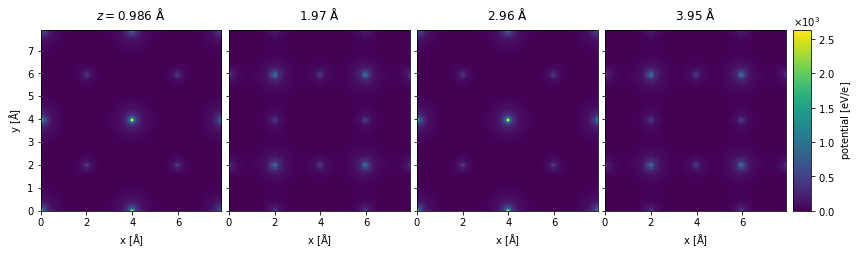

In [114]:
potential_infinite = abtem.Potential(
    repeated_srtio3,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="infinite",
)

potential_infinite[::6].show(
    project=False, figsize=(14, 5), common_color_scale=True, cbar=True,
);

Using infinite projections can be *much* faster, especially for potentials with a large numbers of atoms. As shown by the time below, the potential takes less than 0.5 s to calculate, which you may compare this to the finite projection calculated above that took 4 s. The error introduced by using infinite integrals is in most cases negligible compared to other sources of error. 

In [11]:
potential_infinite.build().compute();

[########################################] | 100% Completed | 106.80 ms


## Crystal potentials

Calculating the potential is generally not a significant cost for simulations where the same potential is used in many runs of the multislice algorithm. However, for simulations that require just one or a few wave functions, such as HRTEM and CBED, it can also be an advantage to use the a periodic crystal potential.

The `CrystalPotential` allows fast calculation for potentials of crystals by tiling a repeating unit of the potential. Below we create a `CrystalPotential` by tiling the already calculated finite projected potential.

In [12]:
crystal_potential = abtem.CrystalPotential(
    potential_unit=potential_array, repetitions=(5, 5, 10)
)

crystal_potential.build().compute();

[########################################] | 100% Completed | 512.71 ms


We also implement a fast frozen phonon algorithm for crystal potentials by reshuffling precalculated slices {cite}`drprobe`; see our walkthrough on [frozen phonons](walkthrough:frozen_phonons).